Here we set the model to run using CPU. By doing this we can inspect the model using the CPU while we train another using the GPU.

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import requests
from datetime import datetime
# from PIL import Image
from functools import reduce
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.manifold import TSNE

In [21]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [3]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, EarlyStopping

In [4]:
from tensorflow.keras.datasets import mnist

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [12]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1)) 
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### Load model

In [7]:
autoencoder = tf.keras.models.load_model('./ae_model_50.hdf5')

In [8]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 8)           584       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 14, 14, 8)         0   

#### latent model

In [9]:
# input_img = autoencoder.get_layer('input_2').output
# encoded = autoencoder.get_layer('max_pooling2d_10').output
input_img = autoencoder.get_layer('input_1').output
encoded = autoencoder.get_layer('max_pooling2d_1').output
latent_model = Model(input_img, encoded)

In [10]:
input_img.shape

TensorShape([None, 28, 28, 1])

In [11]:
_, IMG_HEIGHT, IMG_WIDTH, _ = input_img.shape
IMG_HEIGHT, IMG_WIDTH

(28, 28)

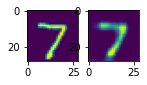

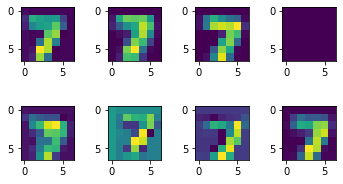

In [20]:
def plot_latents(input_image):
#     test_im = Image.open(input_image).convert('RGB')
#     test_im = test_im.resize((IMG_HEIGHT, IMG_WIDTH))a
#     test_ar = np.asarray(test_im) / 255
#     test_ar = np.expand_dims(test_ar,0)
    test_ar = input_image
    pred = autoencoder.predict(test_ar)
    
    for real, coded in zip(test_ar, pred):
        plt.figure(figsize = (2,4))
        plt.subplot(1,2,1)
        plt.imshow(real[:,:,0])
        plt.subplot(1,2,2)
        plt.imshow(coded[:,:,0])   
    
    coded_image = latent_model.predict(test_ar)
    coded_dims = coded_image.shape[-1]

    plt.figure(figsize = (5,3))
    for i in range(coded_dims):
        plt.subplot(int(np.ceil(coded_dims)/4),4, i+1)
        plt.imshow(coded_image[0, :, :, i])
    plt.tight_layout()    
    
    return pred, coded_image

_ ,_ = plot_latents(x_test[0:1,:,:,:])

### Latent space representation
https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points

In [69]:
latent_path = './data/FlagsMashupBot/reals_square_png/'
latent_files = [f for f in os.listdir(latent_path) if f.endswith('.png')]

Generate DataFrame with country name, latent representation, real representation

In [70]:
latent_flags = pd.DataFrame()
for f in latent_files:
    test_im = Image.open(latent_path + f).convert('RGB')
    test_im = test_im.resize((IMG_HEIGHT, IMG_WIDTH))
    test_ar = np.asarray(test_im) / 255
    test_ar_exp = np.expand_dims(test_ar,0)

    latent_pred = latent_model.predict(test_ar_exp)
    code = f.split('.')[0].upper()
    country_info = info[info.alpha3Code == code].iloc[0]
    one = {
        'code': code, 
        'name': country_info.name, 
        'file': f, 
        '3d_latent': np.squeeze(latent_pred[0, :, :, :]),
        '1d_latent': np.ravel(np.squeeze(latent_pred[0, :, :, :])),
        '3d_real': test_ar}
    country_df = pd.DataFrame([one], index = [0])
    latent_flags = latent_flags.append(country_df, ignore_index=True)

Real TSNE

In [23]:
np.vstack([np.ravel(tim) for tim in x_test]).shape

(10000, 784)

In [ ]:
import seaborn as sns
from sklearn.metrics import silhouette_score

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

In [24]:
real_tsne = sklearn.manifold.TSNE(n_components=2, random_state=2).fit_transform(np.vstack([np.ravel(tim) for tim in x_test]))
real_data = pd.DataFrame({
        'x': real_tsne[:, 0],
        'y': real_tsne[:, 1],
        'label': y_test})

score: 0.3633441925048828


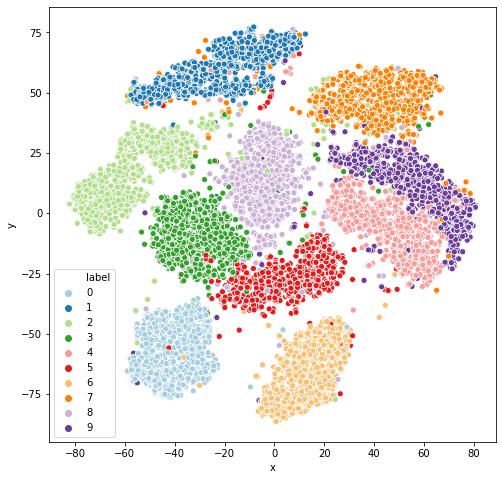

In [68]:
print('score: {}'.format(silhouette_score(real_tsne, real_data['label'] )))
fig = plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x='x', y='y', hue='label', data=real_data, palette='Paired')

#### latent space

In [70]:
latent = latent_model.predict(x_test)

In [76]:
latent_1d = np.reshape(latent,  (latent.shape[0], int(reduce(lambda x, y: x*y, np.asarray(latent.shape[1:])))))

In [77]:
latent_tsne = sklearn.manifold.TSNE(n_components=2, random_state=2).fit_transform(latent_1d)
latent_data = pd.DataFrame({
        'x': latent_tsne[:, 0],
        'y': latent_tsne[:, 1],
        'label': y_test})

score: 0.34036844968795776


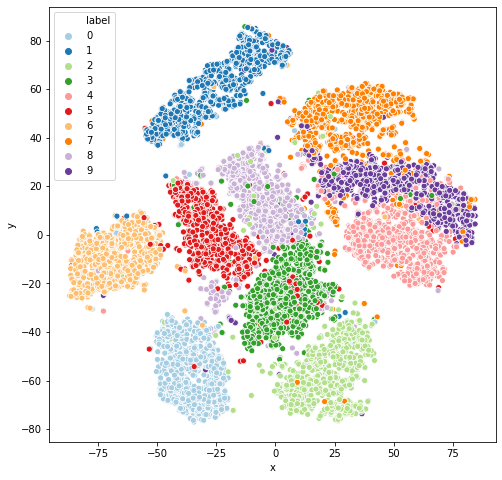

In [80]:
print('score: {}'.format(silhouette_score(latent_tsne, latent_data['label'] )))
fig = plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x='x', y='y', hue='label', data=latent_data, palette='Paired')